# RNN

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

## 데이터 불러오기

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH = '/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch/data/kospi.csv'

In [7]:
df = pd.read_csv(PATH)

In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [9]:
len(df)

431

In [10]:
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


## 텐서 데이터 만들기

In [13]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [14]:
# Dataset
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [15]:
def seq_data(x, y, sequence_length):
    
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length]) # a[2:6] -> 2,3,4,5
        y_seq.append(y[i+sequence_length])
    
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

In [16]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())
#(배치사이즈, 시퀀스의 길이, 변수의 수)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if __name__ == '__main__':


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [17]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

## Hyperparameter 설정

In [21]:
# RNN
input_size = x_seq.size(2) #변수의 수
num_layers = 2
hidden_size = 8

print(x_seq.size())
print(input_size)
#레이어와 히든 스테이트를 너무 많이 늘리면 정보를 받아들일 수 있는 양이 많아 진다는 의미
#때문에, 너무 많이 늘리면 오버피팅이 발생할 수 있음

torch.Size([426, 5, 4])
4


## 모델 구축

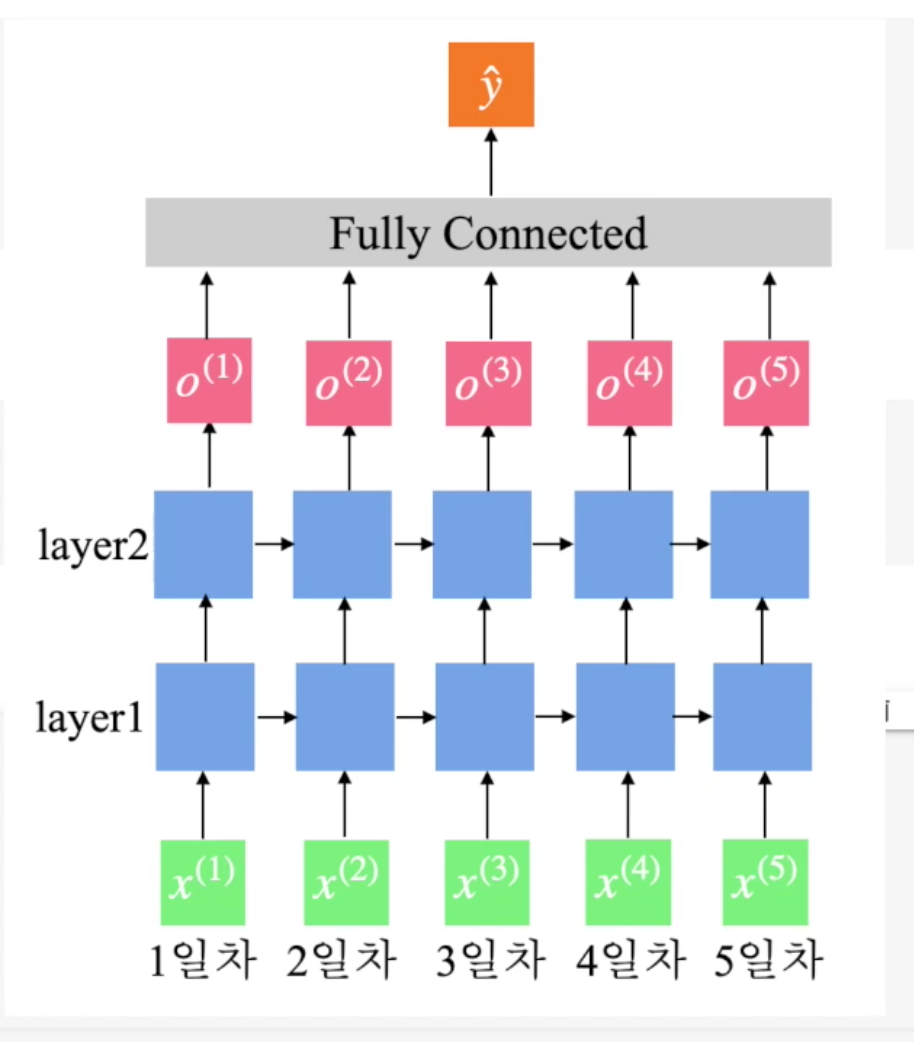

many to many 아키텍쳐를 활용해서 각 일자마다 예측값을 출력한 후

fc레이어를 통해 하나로 펼친다.


In [22]:
class VanillaRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device =device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #batch_first를 통해 데이터의 순서를 배치가 먼저오게 바꿔준다.
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid()) #hidden_size =8은 각일자별 히든 스테이트가 8개 나온다, sequence_lengt는 5일 이 둘을 곱하면 40개의 노드가 나온다.
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로 부터 나온 output feature 반환, hn: hidden state 반환
        out = out.reshape(out.shape[0], -1) # many to many 전략
        out = self.fc(out)
        return out

In [23]:
model = VanillaRNN(input_size=input_size, 
                   hidden_size=hidden_size, 
                   sequence_length=sequence_length, 
                   num_layers=num_layers, 
                   device=device).to(device)

In [24]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200 
optimizer = optim.Adam(model.parameters(), lr=lr)


## 모델 학습하기

In [25]:
loss_graph = []
n = len(train_loader)
print(n)

for epoch in range(num_epochs): #epoch loop
    running_loss = 0.0
    
    for data in train_loader: #배치 데이터 loop
        
        seq, target = data # 배치 데이터 
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

10
[epoch: 0] loss: 0.0216
[epoch: 100] loss: 0.0010


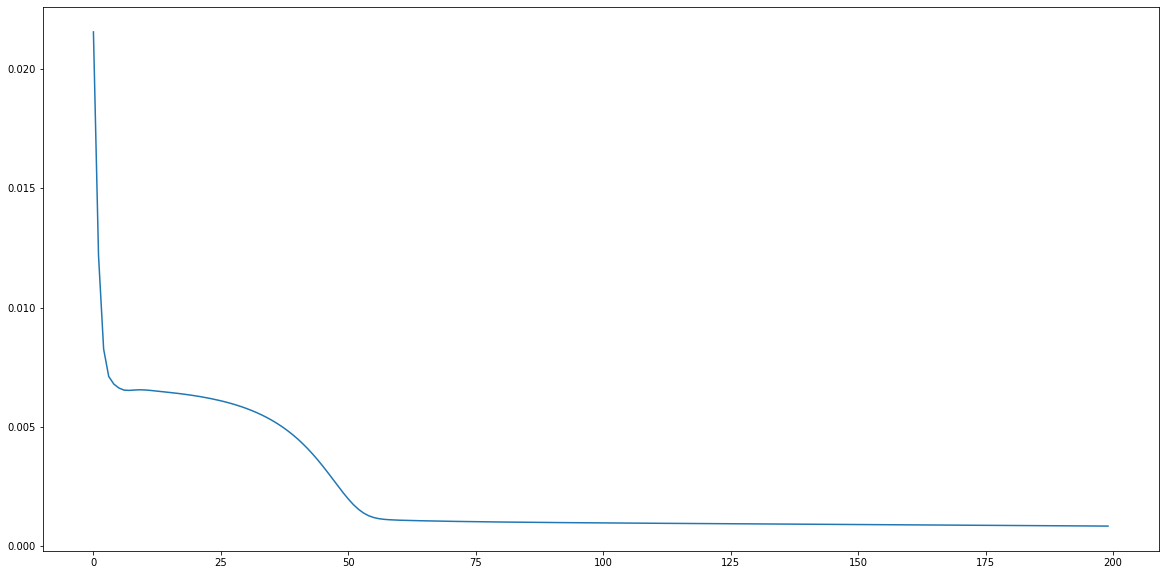

In [26]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show() 

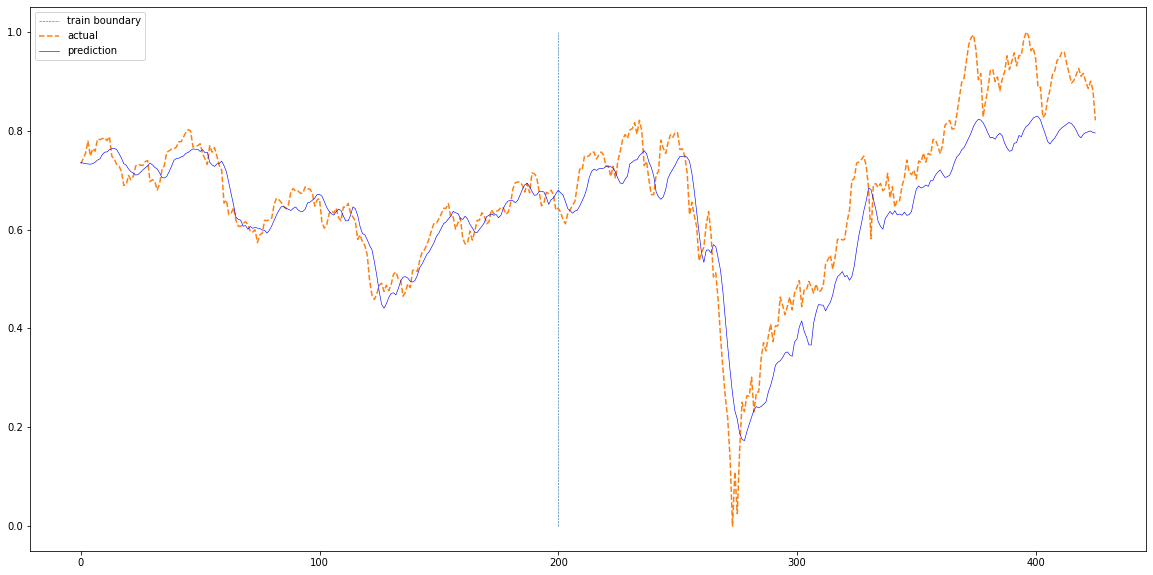

In [27]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []
   
        for data in train_loader:
            seq, target = data # 배치 데이터 
            #print(seq.size())
            out = model(seq)
            train_pred += out.cpu().numpy().tolist()
            
        for data in test_loader:
            seq, target = data # 배치 데이터 
            #print(seq.size())
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()
    total = train_pred+test_pred       
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred),np.linspace(0,1,100),'--', linewidth=0.6)
    plt.plot(actual,'--')
    plt.plot(total,'b', linewidth=0.6)
    
    
    plt.legend(['train boundary','actual','prediction'])
    plt.show() 
    
plotting(train_loader, test_loader, df['Close'][sequence_length:].values)        

## Commit


In [29]:
cd/content/drive/MyDrive/Git_link/Deeplearning/pytorch_basic

/content/drive/MyDrive/Git_link/Deeplearning/pytorch_basic


In [30]:
!git config --global user.email "injaeda7@gmail.com"
!git config --global user.name "SEOINJAE"

In [ ]:
!git pull

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/SEOINJAE/Deeplearning
   e5cda54..fe0ea26  master     -> origin/master


In [ ]:
!git add .

In [ ]:
!git commit -m "chapter 6 done"

In [ ]:
!git push